## Notes

In [ ]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
# These sections are encouraged to be altered! (Of course, you can change all of the code!)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

You can save animations by running them in the HTML5 form, and downloading them manually (hover over the video player and it should show a 'download' option). I've saved the individual frames to seperate files, but haven't found a way to reanimate them.

exno and figno are the excercise number and figure number, each of which can be viewed in the original version of this file (chile2010b.ipynb)

All reference to Manning, including use of the phrase "Manning's value", "Manning's", or "Mann", refers exclusively to Manning's coefficient of friction (or roughness), also known as Manning's n. 

# Notebook setup

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML, Image as ipyImage
from PIL import Image
from os import environ, path, mkdir, remove
from importlib import import_module
from shutil import rmtree, copyfile
from glob import glob
from distutils.dir_util import copy_tree

In [4]:
print("CLAW =",environ['CLAW'])
print("FC =",environ['FC'])

CLAW = /home/jack/clawpack_src/clawpack-v5.7.0
FC = gfortran


In [5]:
nbtools.make_exe(new=True,verbose=True)

Executing shell command:   make new
Done...  Check this file to see output:


/home/jack/clawpack_src/clawpack-v5.7.0/apps/notebooks/geoclaw/chile2010b/compile_output.txt

In [6]:
run maketopo.py  # download the topo file and create the dtopo file

Skipping http://depts.washington.edu/clawpack/geoclaw/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: /home/jack/clawpack_src/clawpack-v5.7.0/geoclaw/scratch/etopo10min120W60W60S0S.asc
Mw =  8.92090917610599
*** Not regenerating dtopo file (already exists): /home/jack/clawpack_src/clawpack-v5.7.0/geoclaw/scratch/dtopo_usgs100227.tt3


Make save paths if not found.

In [7]:
save_paths = '_saved', '_saved/_plots', '_saved/_anim'
for targ in save_paths:
    if path.isdir(targ) == False:
        mkdir(targ)

Clear old data files and diretories

In [8]:
for k in range(1,11):
    try:
        remove('setrun_{}.py'.format(k))
        remove('plot_output_{}.txt'.format(k))
        remove('run_output_{}.txt'.format(k))
        rmtree('_plots_{}'.format(k))
        rmtree('_output_{}'.format(k))
    except Exception:
        pass

# Functions

In [9]:
def old_clear():    
    old_data = 'setrun_{}.py', 'plot_output_{}.txt', 'run_output_{}.txt'
    old_paths = '_plots_{}', '_output_{}'
    for k in range(1,11):
        for targ in old_data:
            if path.isfile(targ.format(k)) == True:
                remove(targ.format(k))
        for targ in old_paths:           
            if path.isdir(targ.format(k)) == True:
                rmtree(targ.format(k))

## Initiate data compilation

Initiate changes to be written to the *.data files

In [10]:
def init_comp(exno, anim123 = False, plots = False, gaugemap = False, gtype = 'stationary', out = False):
    
    if plots == True:
        comp_manns = range(1, amount_manns + 1)
    # If user is not going to plot curves, only 2 manning's values are neccessary to be compiled
    elif plots == False:
        comp_manns = anim_manns
        
    old_clear()
    print("Loading...")

    for element in comp_manns:
        copyfile("setrun.py", "setrun_{}.py".format(element))
        mod = importlib.import_module("setrun_{}".format(element))
        rundata = mod.setrun()
        # Changes to the original setrun.py
        #---------------------------------------
        # Change Manning's
        rundata.geo_data.manning_coefficient = manns[element - 1]
        # Change output times:
        rundata.clawdata.output_style = exno #This is the difference from ex1 to ex2 in the animation
        rundata.clawdata.output_times = linspace(3.5,8,19) * 3600.
            # Change gauge location:
        from clawpack.amrclaw.data import GaugeData
        rundata.replace_data("gaugedata", GaugeData())  # clear old gauge data
        rundata.gaugedata.gauges = []   # empty list
        rundata.gaugedata.gtype = gtype    
        
        if anim123 == True:
            gplot_amount = 2
        else:
            gplot_amount = len(dict_gauge)
        for j in range(gplot_amount):
            rundata.gaugedata.gauges.append([det[j][0], det[j][1], det[j][2], det[j][3], det[j][4]]) # not currently close to epicentre gauge
        if gaugemap == True:
            if element != comp_manns[0]:
                    return
            rundata.amrdata.amr_levels_max = 3
            rundata.amrdata.refinement_ratios_x = [2,2]
            rundata.amrdata.refinement_ratios_y = [2,2]
            rundata.amrdata.refinement_ratios_t = [2,2]
            rundata.regiondata.regions = []  # empty list of regions
            rundata.regiondata.regions.append([3, 3, 0., 1e9, -120,-60, -60,0])
            # now comp_manns has length of 1, so user will see '100% complete'
            comp_manns = [1]
        #---------------------------------------
        compiler(rundata, element, comp_manns, out)
    if plots == False:
        return anim_manns

## Compile data

Write (any changes made by the user to) \*.data files, and then run the code from these files to create fortran data and images to be used in animation. 

In [11]:
def compiler(rundata, element, comp_manns, out = False):
    # create *.data files from parameters in setrun.py
    rundata.write()
    # Run the code from the *.data files
    nbtools.make_output_and_plots(label="_{}".format(element), verbose = out)
    print("{:.0%} complete".format((comp_manns.index(element) + 1)/(len(comp_manns))))

## Show animation

In [12]:
def show_anim(anim, form = 5):
    if form == 'js':
        html_version = HTML(anim.to_jshtml())
    else:
        if form != 5:
            print('format not recognised, defaulting to HTML5')
        html_version = HTML(anim.to_html5_video())

    return html_version

## Figures to animate

Concatenate frames to be used in animation, then creating the user-facing animation. 

In [13]:
def stitch_anim(anim_area, form = 5):
    if anim_area == 'Full map':
        frames = 5
        exno = 1
        figno = 0
        extra = ''
    
    elif anim_area == 'North west coast':
        frames = 19
        exno = 2
        figno = 1
        extra = 0
        
    else:
        print ("Error : Check the animation area was entered correctly")
    
    if path.isdir('_plots') == False:
        mkdir('_plots')
    
    old_frames = glob('_plots/*')
    for f in old_frames:
        remove(f) 
        
    for a in range(exno - 1 ,frames + 1):
        im = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[0],a, figno))
        im_alt = Image.open('_plots_{}/frame{:04d}fig{}.png'.format(anim_manns[1], a, figno))
        dst = Image.new('RGB', (im.width + im_alt.width, im.height))
        dst.paste(im, (0, 0))
        dst.paste(im_alt, (im.width, 0))
        dst.save('_plots/frame{:04d}fig{}.png'.format(a, figno))
        

    anim = animation_tools.animate_from_plotdir('_plots', figno)
    
    anim_path = anim_dir + "/{}".format(anim_area.replace(" ","_"))
    if path.isdir(anim_path) == False:
        mkdir(anim_path)
        copy_tree("_plots", anim_path)
    print('Figures for animation saved to:', anim_path)
        
    print('\nMannings n = {} on left animation, and n = {} on right '\
          'animation'.format(choose_manns[anim_manns[0]], choose_manns[anim_manns[1]]))
    
    return show_anim(anim, form)

## Import gauge data

In [14]:
def gauge_data():
    from setplot import setplot
    plotdata = setplot()
    # reset variables
    h = [None] * (amount_manns)
    u = [None] * (amount_manns)
    v = [None] * (amount_manns)
    mu = [None] * (amount_manns)
    mv = [None] * (amount_manns)
    t = [None] * (amount_manns)
    eta = [None] * (amount_manns)

    for k in range(amount_manns):
        plotdata.outdir = '_output_{}'.format(k + 1)
        # get gauge data
        g = plotdata.getgauge(gauge_num)
        t[k] = g.t / 3600.  # convert to hours
        mu[k] = g.q[1,:] # u = east-west momentum
        mv[k] = g.q[2,:] # v = north-south momentum
        eta[k] = g.q[3,:]   # eta = h + B (depth plus bathymetry)
        h[k] = g.q[0,:]       # water depth
        u[k] = g.q[1,:] / h[k]  # u = east-west velocity
        v[k] = g.q[2,:] / h[k]  # v = north-south velocity
        
    if gtype == 'lagrangian':
        dis_lat = [None] * amount_manns
        dis_lon = [None] * amount_manns
        for j in range(amount_manns):
            dis_lat[j] = empty([len(mu[j])])
            dis_lon[j] = empty([len(mv[j])])
            for i in range(len(mu[j])):       
                dis_lat[j][i] = (det[list(dict_gauge).index(gauge_name)][1] - mu[j][i]) * 110045 # number is the approximate length in meters of a degree of latitude
            for h in range(len(mv[j])):   
                dis_lon[j][h] = (det[list(dict_gauge).index(gauge_name)][2] - mv[j][h]) * 87870.18 # --""-- longitude, both found on https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps

    else:
        dis_lat = 0
        dis_lon = 0
    
    return t,eta,u,v,mu,mv,dis_lat,dis_lon

## Parameterise graph

In [15]:
def plotter_details(measure):
    if measure == 'height':
        var = eta
        plot_amount = 1
        direct = ['','']     
        yunit = 'meters'
        heading = 'Sea surface elevation at {} gauge'.format(gauge_name)

    elif measure == 'velocity':
        var = [u,v]
        plot_amount = 2
        direct = ['east-west', 'north-south']
        yunit = 'meters per second'
        heading = 'velocity at {} gauge'.format(gauge_name)
    
    elif measure == 'discharge':
        var = [mu,mv]
        plot_amount = 2
        direct = ['east-west', 'north-south']
        yunit = 'dishcharge'
        heading = 'discharge at {} gauge'.format(gauge_name)
        
    elif measure == 'travel':
        var = [dis_lat, dis_lon]
        plot_amount = 2
        direct = ['east-west', 'north-south']
        yunit = 'meters'
        heading = 'displacement of {} gauge'.format(gauge_name)
        
    return var, plot_amount, direct, yunit, heading

## Plot graph

In [16]:
def plotter(measure):
    if gtype == 'lagrangian' and measure != 'travel':
        print('skipping plot, as gauge type must be "stationary" to plot {}'.format(measure))
        skip = True
    elif gtype == 'stationary' and measure == 'travel':
        print('skipping plot, as gauge type must be "lagrangian" to plot {}'.format(measure))
        skip = True
    else:
        skip = False
    
    if skip == False:
        var, plot_amount, direct, yunit, heading = plotter_details(measure)
        if plot_amount == 1:
            grid()
            for k in range(amount_manns):
                plot(t[k],var[k], linestyle = line[k][0], color = line[k][1], label="Manning's n = {:.3f}".format(manns[k]))
            title('{}'.format(heading))
            legend()
            xlabel('Hours since earthquake')
            ylabel(yunit)

        elif plot_amount == 2:
            for l in range(2):
                subplot(1, 2, (l+1))
                grid()
                for k in range(amount_manns):
                    plot(t[k], var[l][k], linestyle = line[k][0], color = line[k][1], label="Manning's n = {:.3f}".format(manns[k]))
                title('{} {}'.format(direct[l], heading))
                legend()
                xlabel('Hours since earthquake')
                ylabel(yunit)

        if gtype == 'lagrangian':
            ticklabel_format(useOffset = False, style='plain')

        tight_layout()
        gcf().set_size_inches(14,6)
        savefig('_saved/_plots/manns_{}/{}-gauge_{}.png'.format(manns, gauge_name.replace(' ','_'), measure))
        show()

## Plot comparison graph

Plots the graph which compares the simulated data with the real data of gauge 32412

In [17]:
def plotter_compare():
    if gtype == 'lagrangian':
        print('Comparison can only be performed on "stationary" guage type')
    else:
        ax = gca()

        xmin, xmax, ymin, ymax = (3, 7, -0.20, 0.30)

        for k in range(amount_manns):
            ax.plot(t[k],eta[k], linestyle = line[k][0], color = line[k][1], label="Manning's n = {:.3f}".format(manns[k]))
        ax.plot(0,0,color='k', label="Real life data")
        ax.legend()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel('Hours since earthquake')
        ax.set_ylabel('Meters')
        ax.set_title('Sea surface elevation at gauge 32412')

        ax.set_zorder(2)
        ax.set_facecolor('none')

        ax_tw_x = ax.twinx()
        ax_tw_x.axis('off')
        ax2 = ax_tw_x.twiny()

        im = imread('gauge32412-actual-detide.png')
        ax2.imshow(im, extent=[xmin, xmax, ymin, ymax], aspect='auto')
        ax2.axis('off')

        gcf().set_size_inches(14,6)
        savefig('_saved/_plots/manns_{}/{}-compare_gauge_height.png'.format(manns, gauge_name.replace(' ','_')))
        show()

# Custom parameters

## Manning's values

If true, Manning values will be a family, if false, they will be custom

In [18]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
family_mann = False
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Family of Manning's values

Assign Manning's values as a family, spaced out and centered around a middle value. 

Please let the amount of Manning's values be no less than 2.

Note : Each value may take 1-2 minutes to plot dependent on your machine.

In [19]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
amount_manns = 10 # Amount of Manning's values to create 
mid_mann = 0.5 # Middle Manning's value
space_manns = 0.1 # Space between each Manning's value. I.e, to plot 3 Manning's values, with middle value 0.05, and space value 0.02/
                    # The total created Manning's values would be [0.03, 0.05, 0.07]
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Custom Manning's values

Dictionary of custom mannings values, these can be inserted in cust_manns in the second cell below to be used in the simulation.

Format : 'Description/name' : Manning's n value

In [20]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
dict_mann = {'test':5,
            'geoclaw_tsunami':0.025,
            'yanigasawa_koshimura_2009_mangrove':0.04,
            'yanigasawa_2009_vegitation':0.05,
            'yanigasawa_2009_buildings':0.06,
            'koshimura_2009_low_urban':0.053,
            'koshimura_2009_med_urban':0.094,
            'koshimura_2009_high_urban':0.172,
            'kotani_1998_coast':0.025,
            'kotani_1998_farmland':0.02,
            'kotani_1998_forest':0.03
           }
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [21]:
for key in dict_mann:
    if (len(dict_mann) - 1) != list(dict_mann).index(key):
        print("'" + key + "'" + ",")
    else:
        print("'" + key + "'")

'test',
'geoclaw_tsunami',
'yanigasawa_koshimura_2009_mangrove',
'yanigasawa_2009_vegitation',
'yanigasawa_2009_buildings',
'koshimura_2009_low_urban',
'koshimura_2009_med_urban',
'koshimura_2009_high_urban',
'kotani_1998_coast',
'kotani_1998_farmland',
'kotani_1998_forest'


Custom manning's values to plot (if not intending to plot a family of curves): simply run the two cells above, then copy and paste the selected Manning's values you wish to use from the output. Choose at least 2 values.

In [22]:
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
cust_manns = [
            'koshimura_2009_med_urban',
            'koshimura_2009_high_urban'
            ]
 #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

## Gauges

custom locations to plot gauges at. If unsure, just copy and past this, and replace the named parts (try to keep location description under 35 characters, and keep latitude and longitude from 1-3 decimal places to avoid float miscalculations when plotting):

'location description':[number(0-999) , latitide, longitude, time start(default to 0.), time steps(default to 1.e10)]

hint: area wave resides in first hour : [-85,-72,-38,-25]

The land border is not the same as that on google maps, so it may be a case of trial and error to show your desired gauge if you are trying to plot very near the coast. For example: The Constitución coast gauge is 6km west of the coast coordinates given on google maps. I have found that plotting 5km or closer often ends in failure to plot velocity, as the height at this gauge is given as 0 (i.e the area being plotted on is land).

In [23]:
dict_gauge = {'123':[123, -77.3, -12.3, 3.5*3600, 1.e10],
            '32412':[32412, -86.392, -17.975, 3*3600, 1.e10],
            'epicenter':[101,-72.733,-34.909, 0., 1.e10], 
            'Far point': [2,-119.999, -0.001, 0., 1.e10],
            'Alejandro Selkirk Island west coast': [3,-80.757, -33.768, 0., 1.e10], 
            'Robinson Crusoe Island west coast': [4,-78.771, -33.669, 0., 1.e10],
            'Constitución coast (6km west)': [1002,-72.500, -35.331, 0., 1.e10]    
           }

gtypes is gauge types, which can either be 'stationary', or 'lagrangian', or both. Note: stationary gauges only plot velocity, height and discharge; lagrangian gauges only plot displacement.

Plotting all gauge types takes twice as long as plotting either lagrangian or stationary alone. For 10 manning's coefficients, expect to wait around 20-25 minutes to complete.

In [24]:
#vvvvvvvvvvvvvvvvvvvvvvvv
gtypes = ['stationary', 'lagrangian']
#^^^^^^^^^^^^^^^^^^^^^^^^

# Initialise parameter choice

Note : All manning values are shown in their absolute value (the program does not display negative values any differently from positive ones)

In [25]:
choose_manns = {}

if family_mann == True:
    manns = [None] * amount_manns

        
elif family_mann == False: 
    manns = [None] * len(cust_manns)
    for k in range(len(cust_manns)): 
        manns[k] = dict_mann[cust_manns[k]]
    manns.sort()
        
amount_manns = len(manns)
    
for k in range(amount_manns):
    if family_mann == True:
        if amount_manns%2 == 0:
            manns[k] = abs(mid_mann + (k + 1 - (amount_manns)/2) * space_manns)
        else:
            manns[k] = abs(mid_mann + (k + 1 - (amount_manns + 1) /2) * space_manns)
            
    choose_manns[k+1] = manns[k] 

In [26]:
det = [None] * len(dict_gauge)

for key in dict_gauge:
    k = list(dict_gauge).index(key)
    det[k] = dict_gauge[key]

# Show additional parameters

Some additional notebook parameters (which are able to be changed).

In [27]:
from setrun import setrun
showdata = setrun()

##############################################
show_cfl_desired = showdata.clawdata.cfl_desired
show_cfl_max = showdata.clawdata.cfl_max
if showdata.clawdata.order == 1:
    show_order = 'Godunov'
else:
    show_order = 'Lax-Wendroff plus limiters'
    
if showdata.clawdata.transverse_waves == 0:
    show_transverse_waves = 'Donor cell'
elif showdata.clawdata.transverse_waves == 1:
    show_transverse_waves = 'Corner Transport Upwind'
else:
    show_transverse_waves = 'Corner Transport Upwind + corrections'

show_num_waves = showdata.clawdata.num_waves

show_limiter = str(showdata.clawdata.limiter).replace("'","").replace("[","").replace("]","")

if showdata.clawdata.use_fwaves == True:
    show_waves = 'F-waves'
else:
    show_waves = 'Classic waves'
    
show_frac_step = showdata.clawdata.source_split
show_coriolis = str(showdata.geo_data.coriolis_forcing)
show_fric_depth = "{:.2e}".format(showdata.geo_data.friction_depth)
    
###############################################
table_data = [
    ['Desired Courant number', show_cfl_desired],
    ['Maximum Courant number', show_cfl_max], 
    ['Riemann solver', show_order],
    ['Wave propogation method', show_transverse_waves],
    ['Number of waves in Riemann Solution', show_num_waves],
    ['Limiters', show_limiter],
    ['Wave type',show_waves],
    ['Fractional step algorithm', show_frac_step],
    ['Coriolis force', show_coriolis],
    ['Friction depth', show_fric_depth]
]
layout = "{: <40}" * 2
for row in table_data:
    print(layout.format(*row))
    print('-'*80)

Desired Courant number                  0.75                                    
--------------------------------------------------------------------------------
Maximum Courant number                  1.0                                     
--------------------------------------------------------------------------------
Riemann solver                          Lax-Wendroff plus limiters              
--------------------------------------------------------------------------------
Wave propogation method                 Corner Transport Upwind + corrections   
--------------------------------------------------------------------------------
Number of waves in Riemann Solution     3                                       
--------------------------------------------------------------------------------
Limiters                                mc, mc, mc                              
--------------------------------------------------------------------------------
Wave type                   

# Animations

## Animation set up

In [28]:
# anim_manns = [None] * 2
# if len(choose_manns) > 2:
#     anim_manns[0] = int(input('Choose (1-{}) the first mannings values to'\
#                           ' compare via animation: {}\n'.format(amount_manns, choose_manns)))
#     anim_manns[1] = int(input('Choose (1-{}) the second mannings values to'\
#                           ' compare via animation: {}\n'.format(amount_manns, choose_manns)))
# else:
#     print('Mannings values to be compiled : {}\n'.format(manns))
#     anim_manns[0] = 1
#     anim_manns[1] = 2

In [29]:
# anim_dir = '_saved/_anim/manns_[{},{}]'.format(choose_manns[anim_manns[0]],choose_manns[anim_manns[1]])
# if path.isdir(anim_dir) == False:
#     mkdir(anim_dir)

## North west coast

In [30]:
# anim_manns = init_comp(2, anim123 = True) 
# stitch_anim('North west coast', 'js')

## Full map

In [31]:
# anim_manns = init_comp(1)
# stitch_anim('Full map', 5)

# Plots

## Plot set-up

In [32]:
# line-styler
rainbow = ['#ff0000', '#c3ff00', '#00ff00', '#00ffff', 
          '#0000ff', '#ff00ff']
morse = ['-','-.','--', '.']

line = [None] * amount_manns

for k in range(amount_manns):
    line[k] = [None] * 2
    j = k % len(rainbow)
    l = int(str(k/len(rainbow))[:1]) 
    line[k][0] = morse[l]
    line[k][1] = rainbow[j]

In [33]:
plots_dir = '_saved/_plots/manns_{}'.format(manns)
if path.isdir(plots_dir) == False:
    mkdir(plots_dir)

Display an image of the map with custom gauges to check positioning. Process is faster than running one of the animations above, as it runs for a single Manning's coefficient.

Loading...
100% complete


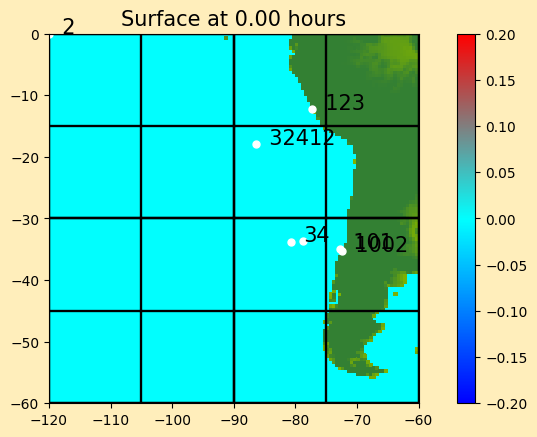

In [34]:
init_comp(1, plots = True, gaugemap = True)
ipyImage(filename='_plots_1/frame0000fig0.png')

## Plot gauges

Loading...
50% complete
100% complete
All plots saved to _saved/_plots/manns_[0.094, 0.172]
*** Could not load DART data file
Read in gauge 123.
Read in gauge 123.
#################-123-#################################


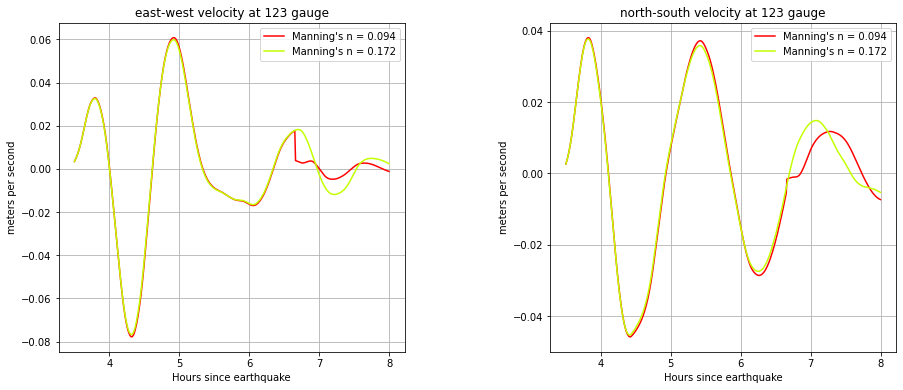

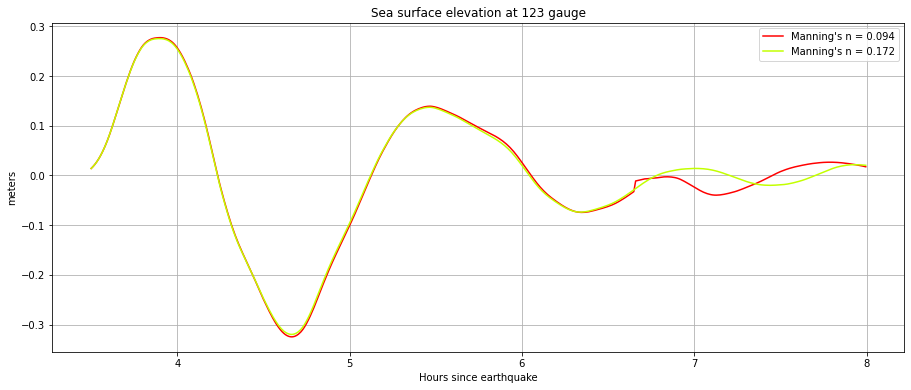

UnboundLocalError: local variable 'var' referenced before assignment

In [35]:
gtypes = ['stationary', 'lagrangian']
for gtype in gtypes:
    init_comp(2, plots = True, gtype = gtype)
    print('All plots saved to _saved/_plots/manns_{}'.format(manns))
    for key in dict_gauge:
        gauge_name = key
        gauge_num = dict_gauge[gauge_name][0]
        t,eta,u,v,mu,mv,dis_lat,dis_lon = gauge_data()
        print('#################-{}-#################################'.format(gauge_name))
        if gtype == 'stationary':
            plotter('velocity')
            plotter('height')
            if gauge_num == 32412:
                plotter_compare()
            plotter('momentum')
        if gtype == 'lagrangian': 
            plotter('travel')